In [90]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense , Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [114]:
def splitData(X,Y,rate):
  X_train = X[:int(X.shape[0]*rate)]
  Y_train = Y[:int(Y.shape[0]*rate)]
  X_val = X[int(X.shape[0]*rate):]
  Y_val = Y[int(Y.shape[0]*rate)-1:]
  return X_train, Y_train, X_val, Y_val

df = pd.read_csv("data/2330_indicators.csv")
X_train = df[:-1].values

y_train = df.loc[1:,['closed']].values
X_train , Y_train , X_val , Y_val = splitData(X_train,y_train,0.8)
print(X_val.shape,Y_val.shape)

(1258, 10) (1259, 1)


In [119]:
sc_X = MinMaxScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.transform(X_val)
sc_Y = MinMaxScaler()
Y_train_sc = sc_Y.fit_transform(Y_train)
Y_val_sc = sc_Y.transform(Y_val)
print(X_val_sc.shape)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [124]:
X_train_steps = []
Y_train_steps = []
for i in range(20, len(X_train_sc)):  # 1258 是訓練集總數
    X_train_steps.append(X_train_sc[i-20:i])
    Y_train_steps.append(Y_train_sc[i])
X_train, Y_train = np.array(X_train_steps), np.array(Y_train_steps)

X_val_steps = []
Y_val_steps = []
for i in range(20,len(X_val_sc)):
    X_val_steps.append(X_val_sc[i-20:i])
    Y_val_steps.append(Y_val_sc[i])
X_val , Y_val = np.array(X_val_steps) , np.array(Y_val_steps)

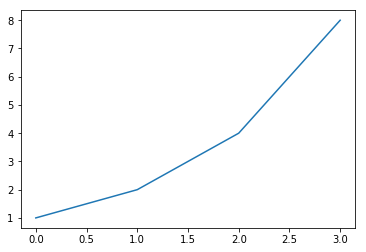

In [125]:
plt.plot([1,2,4,8])

In [126]:

#X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
#X_val = np.reshape(X_val,(X_val.shape[0], 1,1))

model_lstm = Sequential()
model_lstm.add(LSTM(128,input_shape=X_train.shape[1:],activation='relu',kernel_initializer='lecun_uniform',return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(128,return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(128,return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(128,return_sequences=False))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(1))
model_lstm.summary()
model_lstm.compile(loss='mean_squared_error',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 20, 128)           71168     
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 20, 128)           131584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 20, 128)           131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 128)               131584    
__________

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model_lstm = model_lstm.fit(X_train, Y_train, epochs=3000, batch_size=100, shuffle=False,validation_data=(X_val,Y_val),callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_val)
print(y_pred_test_lstm)
y_train_pred_lstm = model_lstm.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_train, y_train_pred_lstm)))
r2_train = r2_score(Y_train, y_train_pred_lstm)

Train on 5008 samples, validate on 1238 samples
Epoch 1/3000
5008/5008 [==============================] - 14s 3ms/step - loss: 0.0496 - acc: 1.9968e-04 - val_loss: 0.2219 - val_acc: 0.0000e+00
Epoch 2/3000
5008/5008 [==============================] - 9s 2ms/step - loss: 0.0173 - acc: 3.9936e-04 - val_loss: 0.0044 - val_acc: 0.0032
Epoch 3/3000
5008/5008 [==============================] - 9s 2ms/step - loss: 0.0164 - acc: 1.9968e-04 - val_loss: 0.0591 - val_acc: 0.0032
Epoch 4/3000
5008/5008 [==============================] - 9s 2ms/step - loss: 0.0061 - acc: 3.9936e-04 - val_loss: 0.0074 - val_acc: 0.0032
Epoch 5/3000
2400/5008 [=============>................] - ETA: 4s - loss: 0.0122 - acc: 8.3333e-04

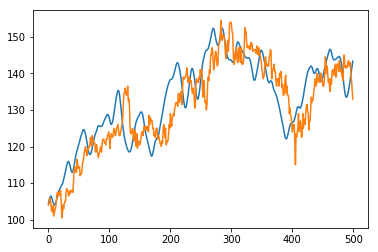

In [87]:
plt.plot(sc_Y.inverse_transform(y_pred_test_lstm)[:500])
plt.plot(Y_val[:500])
plt.show()

In [90]:
model_lstm.save('lstmStock_e2000_b100.h5')